In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
## Import dataset and remove old index column
df = pd.read_csv('20191118_Dataset_for_models.csv')
df = df.iloc[:,1:]

---
## Handle Categorical variables

In [3]:
## Determine number of categories per variable
x = df.select_dtypes(object).columns.to_list()

for each in x:
    y = df[each].value_counts().count()
    print('{} - {}'.format(each, y))

grade - 7
emp_title - 183391
emp_length - 11
home_ownership - 6
verification_status - 3
issue_d - 77
loan_status - 3
title - 18670
addr_state - 51
earliest_cr_line - 707
last_pymnt_d - 78


### Drop variables
- Categorical variables with +10k categories
- Date variables - they've already been used to create new variables
- Drop variables that wouldn't be available before a loan is issued

In [4]:
redundant = ['installment', 'earliest_cr_line','exp_roi','exp_roi_dollar','addr_state']
unkowns = ['issue_d','loan_status','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int',
          'total_rec_late_fee','last_pymnt_d','last_pymnt_amnt','total_months','roi_dollar','roi','pos_roi',
          'target_roi']
large_cat = ['emp_title','title']
drops = redundant + unkowns + large_cat

In [5]:
df = df.drop(drops, axis=1)

### Use Binary encoding for categorical variables
- Binary chosen to limit addition of columns

In [8]:
df.head()

,funded_amnt_inv,term,int_rate,grade_0,grade_1,grade_2,grade_3,emp_length_0,emp_length_1,emp_length_2,emp_length_3,emp_length_4,home_ownership_0,home_ownership_1,home_ownership_2,home_ownership_3,annual_inc,verification_status_0,verification_status_1,verification_status_2,zip_code,dti,delinq_2yrs,credit_age,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,inq_fi,inq_last_12m,avg_cur_bal,chargeoff_within_12_mths,delinq_amnt,mort_acc,num_accts_ever_120_pd,num_tl_30dpd,annualized_roi,pos_ann_roi,target_ann_roi
0,4500.0,36,11.31,0,0,0,1,0,0,0,0,1,0,0,0,1,38500.0,0,0,1,786,4.64,0.0,15.0,0.0,25.0,12.0,0.0,4472,15.3,25.0,25.00,0.0,306.0,29137.0,29200.0,0.0,3.0,2428.0,0.0,0.0,0.0,1.0,0.0,6.74,1,0
1,2475.0,36,13.56,0,0,1,0,0,0,0,1,0,0,0,0,1,42000.0,0,0,1,194,15.09,0.0,15.0,0.0,53.0,3.0,0.0,3319,31.6,6.0,43.95,0.0,0.0,18649.0,10500.0,2.0,1.0,6216.0,0.0,0.0,0.0,0.0,0.0,0.62,1,0
2,4000.0,36,17.97,0,0,1,1,0,0,0,1,0,0,0,1,0,60000.0,0,1,0,760,19.10,0.0,12.0,1.0,38.0,11.0,0.0,382,7.3,18.0,38.00,0.0,0.0,106556.0,5200.0,3.0,3.0,9687.0,0.0,0.0,2.0,1.0,0.0,7.73,1,1
3,1000.0,36,23.40,0,1,0,0,0,0,0,1,1,0,0,0,1,60000.0,0,1,0,435,20.78,0.0,11.0,0.0,59.0,4.0,0.0,13326,72.8,38.0,59.00,0.0,0.0,167564.0,18300.0,0.0,1.0,41891.0,0.0,0.0,0.0,1.0,0.0,14.38,1,1
4,15000.0,36,7.56,0,1,0,1,0,0,0,0,1,0,0,1,0,200000.0,0,0,1,836,2.62,0.0,13.0,0.0,68.0,7.0,0.0,19386,39.2,45.0,68.00,0.0,0.0,175731.0,49500.0,1.0,3.0,25104.0,0.0,0.0,3.0,1.0,0.0,5.16,1,0


In [9]:
obj_cols

['grade', 'emp_length', 'home_ownership', 'verification_status']

In [7]:
obj_cols = df.select_dtypes(object).columns.to_list()

encoder = ce.BinaryEncoder(cols=obj_cols)
df_binary = encoder.fit_transform(df)

df = df_binary

In [7]:
## Drop binary columns with no values
df = df.drop(['grade_0','emp_length_0','home_ownership_0','verification_status_0'], axis=1)

---
## Train/Test Split

In [8]:
## Split dataset into train/test sets with 80/20 split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
train_df.to_csv('train_df.csv')
test_df.to_csv('test_df.csv')

## Separate Train and Test data from labels

In [10]:
## Training data
roi_labels = train_df['annualized_roi'].copy()
pos_labels = train_df['pos_ann_roi'].copy()
target_labels = train_df['target_ann_roi'].copy()
train_df = train_df.drop(['annualized_roi','pos_ann_roi','target_ann_roi'], axis=1)
train_df_cols = train_df.columns

## Testing data
roi_test = test_df['annualized_roi'].copy()
pos_test = test_df['pos_ann_roi'].copy()
target_test = test_df['target_ann_roi'].copy()
test_df = test_df.drop(['annualized_roi','pos_ann_roi','target_ann_roi'], axis=1)
test_df_cols = test_df.columns

## Standardize Train data, apply to Test data

In [11]:
## Train
scaler = StandardScaler()
scaler.fit(train_df)
sc_train = scaler.transform(train_df)
train_df = pd.DataFrame(sc_train)
train_df.columns = train_df_cols

## Test
test_df = scaler.transform(test_df)
test_df = pd.DataFrame(test_df)
test_df.columns = test_df_cols

### Model scoring function

In [12]:
def model_scores(labels, model):
    print('Accuracy: {}'.format(100*accuracy_score(labels, model)))
    print('Precision: {}'.format(100*precision_score(labels, model)))
    print('Recall: {}'.format(100*recall_score(labels, model)))
    print('AUC: {}'.format(100*roc_auc_score(labels, model)))

---
# Random Forest w/ Feature Importance 

In [13]:
%%time
forest_reg = RandomForestRegressor()
forest_reg.fit(train_df, roi_labels)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 2min 12s, sys: 395 ms, total: 2min 12s
Wall time: 2min 12s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [14]:
rf_pred = forest_reg.predict(train_df)
rf_mse = mean_squared_error(roi_labels, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

12.391644911200363

In [15]:
importances = forest_reg.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = df.columns
feature_names = [feature_names[i] for i in indices]

for f in range(0,30):
    print('{}. {} ({})'.format(f + 1, feature_names[f], round(importances[indices[f]],5)))

1. dti (0.07085)
2. int_rate (0.06582)
3. zip_code (0.06362)
4. revol_util (0.05886)
5. avg_cur_bal (0.0566)
6. annual_inc (0.05582)
7. revol_bal (0.05492)
8. funded_amnt_inv (0.05482)
9. tot_cur_bal (0.05355)
10. total_rev_hi_lim (0.05344)
11. mths_since_last_delinq (0.05036)
12. total_acc (0.04717)
13. credit_age (0.04651)
14. mths_since_last_major_derog (0.03804)
15. open_acc (0.03397)
16. tot_coll_amt (0.02009)
17. mort_acc (0.0197)
18. inq_last_12m (0.01898)
19. num_accts_ever_120_pd (0.01781)
20. inq_last_6mths (0.01633)
21. inq_fi (0.01529)
22. delinq_2yrs (0.01186)
23. pub_rec (0.01019)
24. term (0.00755)
25. emp_length_3 (0.00635)
26. emp_length_2 (0.0063)
27. verification_status_2 (0.00604)
28. emp_length_4 (0.00597)
29. emp_length_1 (0.00535)
30. home_ownership_2 (0.00484)


Text(0.5, 0, 'index of the feature')

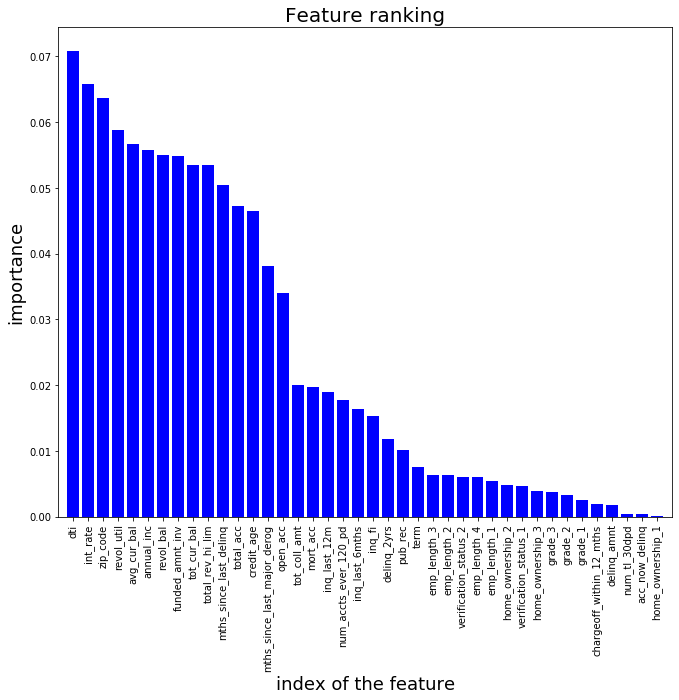

In [16]:
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(train_df.shape[1]), importances[indices],
    color="b", 
    align="center")
feature_names = df.columns
feature_names = [feature_names[i] for i in indices]
plt.xticks(range(train_df.shape[1]), feature_names, rotation=90)
plt.xlim([-1, train_df.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)

---
# PCA

In [17]:
pca_2 = PCA(0.95)
X_reduced = pca_2.fit_transform(train_df)

## Create dataframe from pca array
pca_df = pd.DataFrame(X_reduced)

In [18]:
## How much variance is explained by each component
pca_2.explained_variance_ratio_

array([0.10227327, 0.06309472, 0.05499276, 0.05208141, 0.04712072,
       0.04207718, 0.04100824, 0.03773083, 0.0347589 , 0.0324813 ,
       0.03149972, 0.03014806, 0.02681177, 0.02505504, 0.02497098,
       0.02482837, 0.02445077, 0.02400316, 0.02374916, 0.02308381,
       0.02153696, 0.02061473, 0.01923796, 0.01856776, 0.01761172,
       0.0157046 , 0.01461279, 0.0135183 , 0.01291654, 0.01187515,
       0.01182249, 0.00977548])

In [19]:
print('Train data size: {}'.format(train_df.shape))
print('PCA data size: {}'.format(pca_df.shape))

Train data size: (461023, 40)
PCA data size: (461023, 32)


---
# ROI Prediction (Regression)

### Linear Regression

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(train_df, roi_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
roi_predictions = lin_reg.predict(train_df)
lin_mse = mean_squared_error(roi_labels, roi_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

27.70110955604156

In [22]:
scores = cross_val_score(lin_reg, train_df, roi_labels,
                        scoring='neg_mean_squared_error', cv=10)

In [23]:
rmse_scores = np.sqrt(-scores)

In [24]:
rmse_scores.mean()

27.704097957075646

In [25]:
r2_score(roi_labels, roi_predictions)

0.03291288859181163

### Random Forest Regression

In [26]:
%%time
forest_reg = RandomForestRegressor()
forest_reg.fit(train_df, roi_labels)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 2min 12s, sys: 454 ms, total: 2min 12s
Wall time: 2min 12s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [27]:
roi_rf_pred = forest_reg.predict(train_df)
rf_mse = mean_squared_error(roi_labels, roi_rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

12.38780295389266

In [172]:
%%time
scores = cross_val_score(forest_reg, train_df, roi_labels, scoring='neg_mean_squared_error', cv=10)

CPU times: user 19min 32s, sys: 4.87 s, total: 19min 37s
Wall time: 19min 36s


In [173]:
forest_rsme_scores = np.sqrt(-scores)
forest_rsme_scores.mean()

29.295420643251287

In [174]:
r2_score(roi_labels, roi_rf_pred)

0.8053582952715896

---
# Positive ROI (Classification)

### Percentage of Positive ROI

In [13]:
pos_labels.sum() / pos_labels.shape[0]

0.8096906228105756

### Random Forest

In [14]:
%%time
pos_forest_c = RandomForestClassifier()
pos_forest_c.fit(train_df, pos_labels)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 28.3 s, sys: 217 ms, total: 28.5 s
Wall time: 21.7 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
rf_pred = pos_forest_c.predict(train_df)

In [16]:
x = confusion_matrix(pos_labels, rf_pred)
x

array([[ 84754,   2983],
       [   663, 372623]])

In [17]:
model_scores(pos_labels, rf_pred)

Accuracy: 99.20915008578748
Precision: 99.20581673349201
Recall: 99.82238819564624
AUC: 98.21122715115295


In [18]:
%%time
scores = cross_val_score(pos_forest_c, train_df, pos_labels, scoring='precision', cv=10)

CPU times: user 4min 22s, sys: 3.94 s, total: 4min 26s
Wall time: 3min 18s


In [19]:
print('Cross Validated Precision: {} +/- {}'.format(round((100*scores.mean()),2), round(100*scores.std(),2)))

Cross Validated Precision: 82.79 +/- 0.08


### Logistic Regression

In [182]:
log_reg = LogisticRegression()
log_reg.fit(train_df, pos_labels)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [183]:
lr_pred = log_reg.predict(train_df)

In [184]:
confusion_matrix(pos_labels, lr_pred)

array([[  4290,  83447],
       [  3763, 369523]])

In [185]:
model_scores(pos_labels, lr_pred)

Accuracy: 81.0833732807257
Precision: 81.57780868490187
Recall: 98.99192576201625
AUC: 51.94076951902857


In [186]:
%%time
scores = cross_val_score(log_reg, train_df, pos_labels, scoring='precision', cv=10)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

CPU times: user 53.4 s, sys: 1.88 s, total: 55.3 s
Wall time: 43.4 s


In [187]:
print('Precision: {} +/- {}'.format(round((100*scores.mean()),2), round(100*scores.std(),2)))

Precision: 81.58 +/- 0.04


---
# Target ROI (Classification)
- Binary Classifier for above (positive) and below (negative) the median ROI (11.56%)

### Percentage of Positive Target ROI

In [188]:
target_labels.sum() / target_labels.shape[0]

0.49946965769603685

### Random Forest

In [189]:
forest_c = RandomForestClassifier()
forest_c.fit(train_df, target_labels)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [190]:
rf_pred = forest_c.predict(train_df)

In [191]:
x = confusion_matrix(target_labels, rf_pred)
x

array([[229280,   1476],
       [  4312, 225955]])

In [192]:
model_scores(target_labels, rf_pred)

Accuracy: 98.74453118391057
Precision: 99.35101195527434
Recall: 98.12739124581465
AUC: 98.74387728665604


In [193]:
%%time
scores = cross_val_score(forest_c, train_df, target_labels, scoring='precision', cv=10)

CPU times: user 4min 18s, sys: 3.46 s, total: 4min 22s
Wall time: 3min 10s


In [194]:
print('Cross Validated Precision: {} +/- {}'.format(round((100*scores.mean()),2), round(100*scores.std(),2)))

Cross Validated Precision: 66.43 +/- 0.24


### Logistic Regression

In [195]:
log_reg = LogisticRegression()
log_reg.fit(train_df, target_labels)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [196]:
lr_pred = log_reg.predict(train_df)

In [197]:
lr_prob = log_reg.predict_proba(train_df)

In [198]:
confusion_matrix(target_labels, lr_pred)

array([[134737,  96019],
       [ 57189, 173078]])

In [199]:
model_scores(target_labels, lr_pred)

Accuracy: 66.76781852532304
Precision: 64.31807117879427
Recall: 75.16404869130183
AUC: 66.77671484123933


### Try different thresholds for Target ROI

In [200]:
x = pd.DataFrame(lr_prob)
y = pd.DataFrame({'ROI': roi_labels, 'Target': target_labels}).reset_index(drop=True)
z = pd.concat([x,y], axis=1, ignore_index=True)
z.columns = ['Prob_0','Prob_1','ROI','Target']

In [201]:
thresholds = [0.4, 0.5, 0.625, 0.75, 0.875]
for i in thresholds:
    z[i] = z['Prob_1'].apply(lambda x: 1 if x > i else 0)

In [202]:
z.head()

,Prob_0,Prob_1,ROI,Target,0.4,0.5,0.625,0.75,0.875
0,0.418594,0.581406,14.45,1,1,1,0,0,0
1,0.542360,0.457640,24.94,1,1,0,0,0,0
2,0.480480,0.519520,11.07,1,1,1,0,0,0
3,0.571116,0.428884,11.89,1,1,0,0,0,0
4,0.426232,0.573768,17.27,1,1,1,0,0,0


In [210]:
confusion_matrix(target_labels, z[0.75])

array([[222795,   7961],
       [210011,  20256]])

In [211]:
model_scores(target_labels, z[0.75])

Accuracy: 52.71992937445638
Precision: 71.78651167735762
Recall: 8.796744648603577
AUC: 52.67339009198714


#### Cross Validation of Log Reg

In [212]:
%%time
scores = cross_val_score(log_reg, train_df, target_labels, scoring='precision', cv=10)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

CPU times: user 57.2 s, sys: 2.08 s, total: 59.2 s
Wall time: 47 s


In [213]:
print('Cross Validated Precision: {} +/- {}'.format(round((100*scores.mean()),2), round(100*scores.std(),2)))

Cross Validated Precision: 64.31 +/- 0.2


# Positive ROI Random Forest Tuning

In [20]:
param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [10,20,30]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]},
]

In [21]:
grid_search = GridSearchCV(pos_forest_c, param_grid, cv=5,
                          scoring='precision')

In [22]:
%%time
grid_search.fit(train_df, pos_labels)

CPU times: user 1h 16min 27s, sys: 28 s, total: 1h 16min 55s
Wall time: 5h 16min 11s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='wa

In [23]:
grid_search.best_params_

{'max_features': 30, 'n_estimators': 10}

In [24]:
final_model = grid_search.best_estimator_

In [25]:
final_predictions = final_model.predict(test_df)

In [26]:
final_precision = precision_score(pos_test, final_predictions)

In [27]:
final_precision

0.8311462083381721

In [28]:
final_conf_matrix = confusion_matrix(pos_test, final_predictions)

In [29]:
final_conf_matrix

array([[ 4266, 17448],
       [ 7658, 85884]])

In [30]:
model_scores(pos_test, final_predictions)

Accuracy: 78.2171860900951
Precision: 83.11462083381721
Recall: 91.81330311517821
AUC: 55.72980712542552
